In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch

# Select GPU
torch.cuda.set_device(5)
torch.cuda.current_device()

import warnings
from pathlib import Path
from wrappers.transformer_wrapper import FairseqTransformerHub

import alignment.align as align
from wrappers.utils import visualize_alti
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import pandas as pd
import numpy as np

import logging
logger = logging.getLogger()

logger.setLevel('WARNING')
warnings.simplefilter('ignore')

from dotenv import load_dotenv
load_dotenv()
device = "cuda" if torch.cuda.is_available() else "cpu"

2022-07-20 19:53:12 | INFO | fairseq.tasks.text_to_speech | Please install tensorboardX: pip install tensorboardX


## Load model

In [3]:
data_sample = 'interactive' # generate/interactive
teacher_forcing = False # teacher forcing/free decoding

green_color = '#82B366'
red_color = '#B85450'

In [4]:
# Paths
europarl_dir = Path(os.environ['EUROPARL_DATA_DIR'])
ckpt_dir = Path(os.environ['EUROPARL_CKPT_DIR'])
iwslt14_dir = Path(os.environ['IWSLT14_DATA_DIR'])
gold_dir = Path(os.environ['GOLD_ALIGNMENT_DATA_DIR'])
#ckpt_dir = Path(os.environ['IWSLT14_CKPT_DIR'])

# Choose model
model_type = 'baseline'
seed = 5498 # 2253  2453  5498  9240	9819

hub = FairseqTransformerHub.from_pretrained(
    ckpt_dir / f"{model_type}/{seed}",
    checkpoint_file=f"checkpoint_best.pt",
    data_name_or_path=(europarl_dir / "processed_data/fairseq_preprocessed_data").as_posix(), # processed data
    #(data_name_or_path=iwslt14_dir / "data-bin").as_posix(), 
)

## Get example for analysis

From provided test data (preprocessed folder)

In [5]:
# Get sample from provided test data

if data_sample == 'generate':
    # index in dataset
    i = 29

    sample = hub.get_sample('test', i)

    src_tensor = sample['src_tensor']
    tgt_tensor = sample['tgt_tensor']
    src_tok = sample['src_tok']
    src_sent = sample['src_sent']
    tgt_sent = sample['tgt_sent']
    print(f"\nSource sentence: \t {src_sent}")
    print(f"Target sentence: \t {tgt_sent}")

In [6]:
if data_sample == 'interactive':
    # index in dataset
    i = 120 # index in dataset
    #test_set_dir = europarl_dir / "processed_data/"

    test_set_dir = iwslt14_dir / "tokenized/"
    test_set_dir = gold_dir / "tokenized/"
    src = "de"
    tgt = "en"
    tokenizer = "bpe"
    sample = hub.get_interactive_sample(i, test_set_dir, src,
                                        tgt, tokenizer, hallucination=None)
    src_tensor = sample['src_tensor']
    tgt_tensor = sample['tgt_tensor']
    source_sentence = sample['src_tok']
    target_sentence = sample['tgt_tok']

    print(sample['src_word_sent'])
    print(sample['tgt_word_sent'])

damit ist unsere aussprache über den stand der europäischen union geschlossen .

the debate on the state of the european union is closed .



### Teacher Forcing

In [7]:
if teacher_forcing:
    model_output, log_probs, encoder_out, layer_inputs, layer_outputs = hub.trace_forward(src_tensor, tgt_tensor)

    print("\n\nGREEDY DECODING\n")
    pred_log_probs, pred_tensor = torch.max(log_probs, dim=-1)
    predicted_sentence = hub.decode(pred_tensor, hub.task.tgt_dict)
    pred_sent = hub.decode(pred_tensor, hub.task.tgt_dict, as_string=True)
    print(f"Predicted sentence: \t {pred_sent}")

### Greedy decoding/Beam search

For greedy decoding, set beam=1

In [8]:
if not teacher_forcing:
    tgt_tensor_free = []
    # Add tokens to prefix_tokens to force decoding with initial tokens
    # We use token id = 3 (unk) to generate hallucinations
    # prefix_tokens = torch.tensor([[3]]).to('cuda')
    # inference_step_args={'prefix_tokens': prefix_tokens}
    inference_step_args = None

    print("\n\nBEAM SEARCH\n")
    for pred in hub.generate(src_tensor, beam=4, inference_step_args = inference_step_args):
        tgt_tensor_free.append(pred['tokens'])
        pred_sent = hub.decode(pred['tokens'], hub.task.tgt_dict, as_string=True)
        score = pred['score'].item()
        print(f"{score} \t {pred_sent}")

    hypo = 0 # first hypothesis
    tgt_tensor = tgt_tensor_free[hypo]
    
    # We add eos token at the beginning of sentence and delete it from the end
    tgt_tensor = torch.cat([torch.tensor([hub.task.target_dictionary.eos_index]).to(tgt_tensor.device),
                    tgt_tensor[:-1]
                ]).to(tgt_tensor.device)
    target_sentence = hub.decode(tgt_tensor, hub.task.target_dictionary, as_string=False)

    # Forward-pass to get the 'prediction' (predicted_sentence) when the top-hypothesis is in the decoder input
    model_output, log_probs, encoder_out, layer_inputs, layer_outputs = hub.trace_forward(src_tensor, tgt_tensor)

    print(f"\n\nGREEDY DECODING with hypothesis {hypo+1}\n")
    pred_log_probs, pred_tensor = torch.max(log_probs, dim=-1)
    predicted_sentence = hub.decode(pred_tensor, hub.task.target_dictionary)
    pred_sent = hub.decode(pred_tensor, hub.task.target_dictionary, as_string=True)
    print(f"Predicted sentence: \t {pred_sent}") # result should match beam search when beam=1



BEAM SEARCH

-0.17807471752166748 	 that concludes our debate on the state of the european union .</s>
-0.3190591335296631 	 that concludes the debate on the state of the european union .</s>
-0.3660474419593811 	 this concludes our debate on the state of the european union .</s>
-0.479086697101593 	 that concludes our debate on the european union &apos;s position .</s>


GREEDY DECODING with hypothesis 1

Predicted sentence: 	 that concludes our debate on the state of the european union .</s>


## Layer-wise Analysis

### Attention weights cross-attention

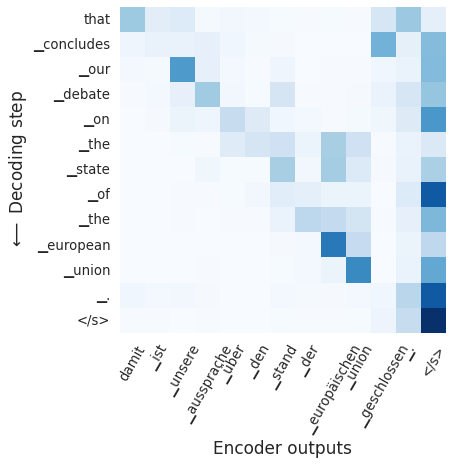

In [9]:
layer = 4

cross_attn_contributions = torch.squeeze(hub.get_contributions(src_tensor, tgt_tensor, 'attn_w', norm_mode='sum_one')['decoder.encoder_attn'])
cross_attn_contributions = cross_attn_contributions.detach().cpu().numpy()
plt.figure(figsize=(6,6))
df = pd.DataFrame(cross_attn_contributions[layer],columns=source_sentence,index=predicted_sentence)
sns.set(font_scale=1.2)
s = sns.heatmap(df, cmap="Blues",square=True,cbar=False)
s.set_xlabel('Encoder outputs', fontsize=17)
s.set_ylabel('$\longleftarrow$ Decoding step', fontsize=17)

plt.tick_params(axis='both', which='major', labelbottom = True, bottom=False, top = False, labeltop=False);
plt.xticks(rotation=60);

mean residual 0.81913716 std 0.09987752


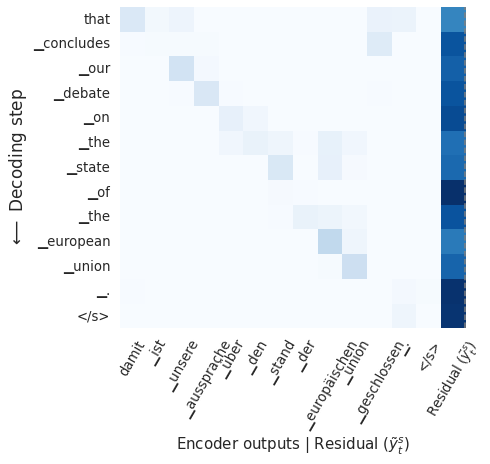

In [10]:
layer = 4

cross_attn_contributions = torch.squeeze(hub.get_contributions(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['decoder.encoder_attn'])
cross_attn_contributions = cross_attn_contributions.detach().cpu().numpy()
plt.figure(figsize=(6.2,6.2))

df = pd.DataFrame(cross_attn_contributions[layer],columns=source_sentence + ['Residual'],index=predicted_sentence)
sns.set(font_scale=1.2)
s = sns.heatmap(df, cmap="Blues",square=True,cbar=False)
s.set_xlabel(r'Encoder outputs | Residual $(\tilde{y}^{s}_{t})$', fontsize=15)
s.set_ylabel('$\longleftarrow$ Decoding step', fontsize=17)


plt.tick_params(axis='both', which='major', labelbottom = True, bottom=False, top = False, labeltop=False);
plt.xticks(ticks = plt.gca().get_xticks(), labels=source_sentence + [r'Residual $(\tilde{y}^{s}_{t})$'], rotation=60)
# for i, xtick in enumerate(plt.gca().get_xticklabels()):
#     plt.gca().get_xticklabels()[i].set_color(green_color)
#plt.gca().get_xticklabels()[-1].set_color(red_color)
plt.axvline(x = len(source_sentence)+0.98, lw=1.5, linestyle = '--', color = 'grey')# ymin = 0, ymax = 15

print('mean residual',df['Residual'].mean(), 'std', df['Residual'].std())


Total decoder layer contributions $[\mathbf{C}_{\widetilde{\mathbf{y}}\gets\mathbf{e}};\mathbf{C}_{\widetilde{\mathbf{y}}\gets\mathbf{y}_{<t}}]$ with the self-attention contributions included

Corresponds to Figure 8-c

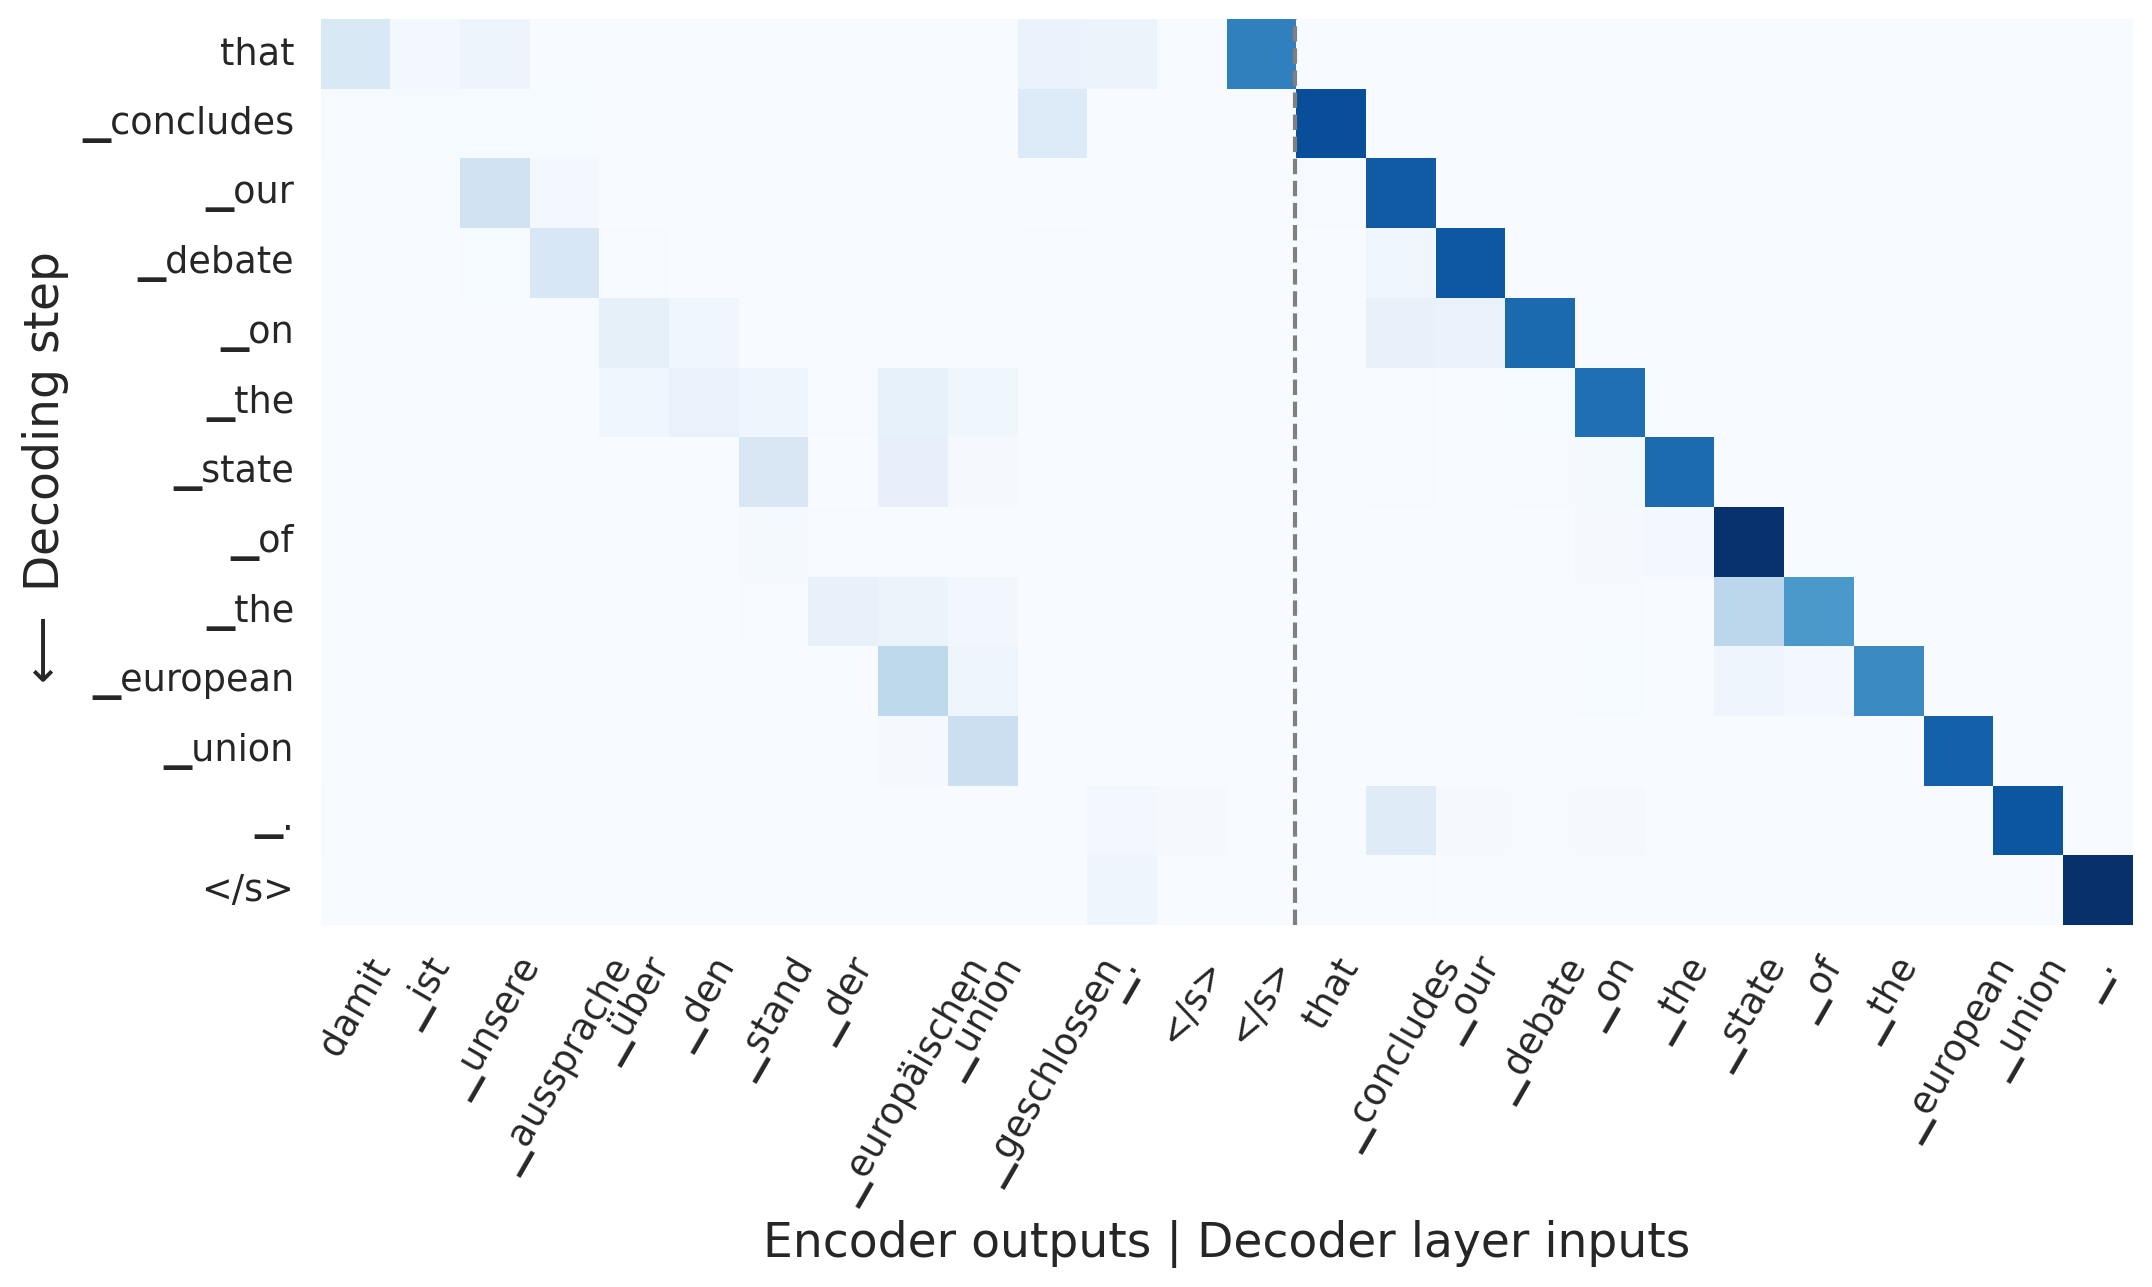

In [11]:
layer = 4
self_dec_contributions = torch.squeeze(hub.get_contributions(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['decoder.self_attn'])#encoder.self_attn
cross_contributions = torch.squeeze(hub.get_contributions(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['decoder.encoder_attn'])#encoder.self_attn
cross_contributions_layer = cross_contributions[layer]

self_dec_contributions_layer = (self_dec_contributions[layer].transpose(0,1)*cross_contributions_layer[:,-1]).transpose(0,1)
cross_contributions_layer = cross_contributions_layer[:,:-1]
final_cross_contributions = torch.cat((cross_contributions_layer,self_dec_contributions_layer),dim=1)
final_cross_contributions_np = final_cross_contributions.detach().cpu().numpy()
plt.figure(figsize=(15,6),dpi=200)
df = pd.DataFrame(final_cross_contributions_np, columns = source_sentence + target_sentence, index = predicted_sentence)
sns.set(font_scale=1.2)
s = sns.heatmap(df,cmap="Blues",square=True, cbar=False)
s.set_xlabel('Encoder outputs | Decoder layer inputs', fontsize=17)
s.set_ylabel('$\longleftarrow$ Decoding step', fontsize=17)
plt.xticks(rotation=60)
plt.axvline(x = len(source_sentence)+0.98, lw=1.5, linestyle = '--', color = 'grey')# ymin = 0, ymax = 15
src_len = len(source_sentence)
tgt_len = len(predicted_sentence)


## ALTI analysis

### ALTI of the encoder

To check the mixing of information inside the decoder

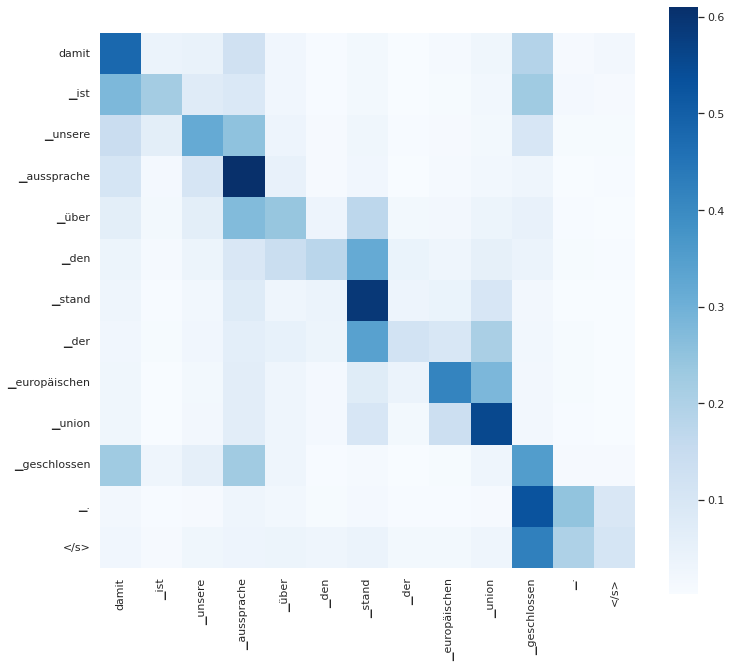

In [12]:
relevances_enc_self_attn = hub.get_contribution_rollout(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['encoder.self_attn']
layer = -1
# Encoder self-attention relevances in last layer (full encoder ALTI)
plt.figure(figsize=(12,12))
df = pd.DataFrame(relevances_enc_self_attn[layer].cpu().detach().numpy(),columns= source_sentence, index= source_sentence)
sns.set(font_scale=1)
sns.heatmap(df,cmap="Blues",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

Attention weights (raw) in the cross attention at selected layer.
Corresponds to Figure 8-a of the paper

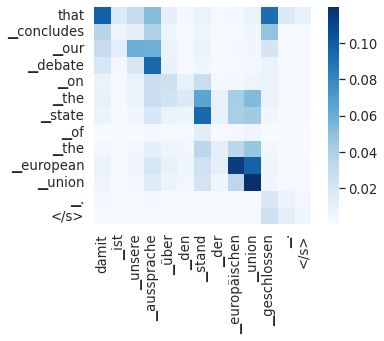

In [13]:
layer = 4

cross_attn_contributions = torch.squeeze(hub.get_contributions(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['decoder.encoder_attn'])
combined_alti_enc_cross = torch.matmul(cross_attn_contributions[layer][:,:-1],relevances_enc_self_attn[-1])
df = pd.DataFrame(combined_alti_enc_cross.detach().cpu().numpy(), columns=source_sentence, index=predicted_sentence)
sns.set(font_scale=1.2)
sns.heatmap(df,cmap="Blues",square=True);

### ALTI+

ALTI+ for the entire model. Last layer heatmap shows relevances of input tokens to the model prediction: $\mathbf{R}^{\text{model}}_{\widetilde{\mathbf{y}}_t \gets \mathbf{x}}$ | $\mathbf{R}^{\text{model}}_{\widetilde{\mathbf{y}}_t \gets \mathbf{\mathbf{y}_{<t}}}$

In [14]:
total_alti = hub.get_contribution_rollout(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['total']

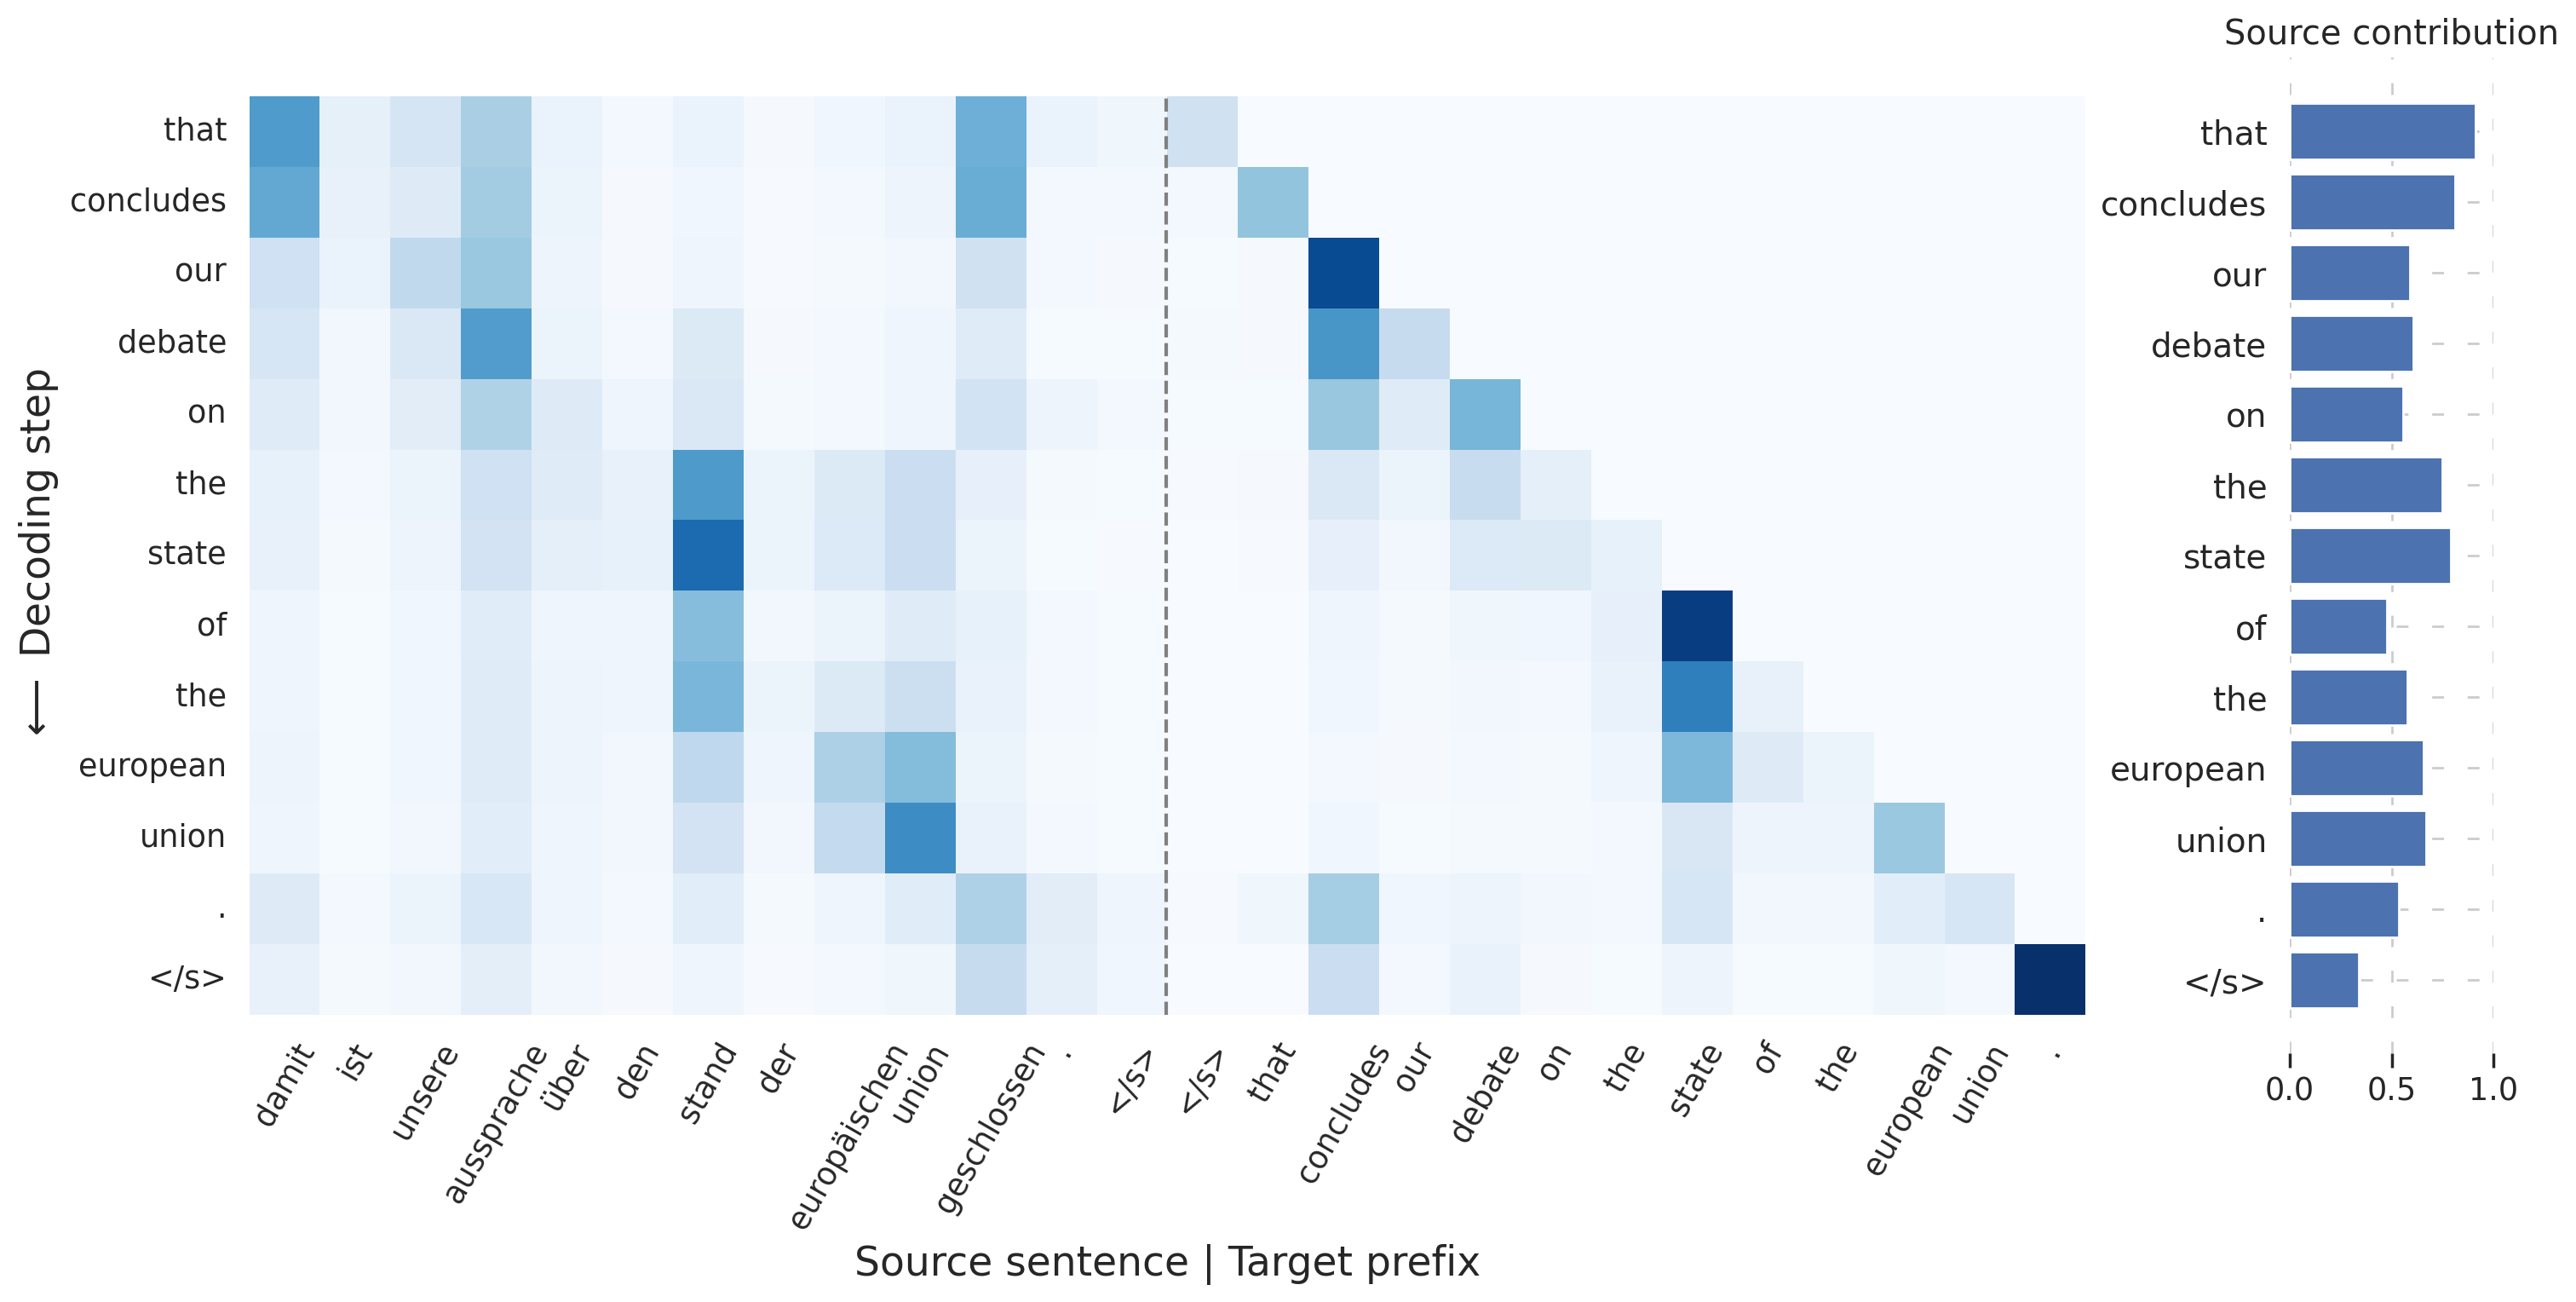

In [15]:
word_level = True
alignment = False # evaluating alignments, predictions (rows) are the reference, (not showing real interpretations)

alti_result, source_sentence_, predicted_sentence_ = visualize_alti(total_alti, source_sentence,
                                                                    [target_sentence[0]] + ['▁' + target_sentence[1]] + target_sentence[2:], predicted_sentence,
                                                                    word_level, alignment, all_layers = False)